ChatGPT is getting a lot of buzz these days. I don't use it much because I don't like to worry about prompts, but my friend uses it to write papers, and my mom uses it to just talk, which makes me feel a little sorry for being an unfriendly son... A neural network called Transformer is the success of language generative models like ChatGPT. A layer called Multihead Attention is repeatedly applied to a sequence of input tokens to form a complex model. In this blog we will focus on a simplified version of Multihead Attention, Singlehead Self-Attention, study what it does, and try to write some code to run it.

# References
- [Formal Algorithms for Transformers](https://arxiv.org/abs/2207.09238)
- [Shumi-Note Transformer](https://github.com/syuntoku14/Shumi-Note/blob/main/notebooks/NN_transformer.ipynb)

# Encoding token sequences
Attention takes a sequence of tokens as an input, so let's encode tokens first.

## Sequence of tokens
A token sequence is literally a sequence consisting of tokens. A token is an element of a finite set. For practical use, this includes substrings obtained by byte pair encoding, but you don't need to worry about that for now. Let $V$ be a set of tokens, numbered $[Nv] := {1, ... , Nv}$ and number them $[Nv] := {1, .... Write $x = x[1: l]$ for the token sequence. Also, let $L$ be the maximum length of the token sequence.

## From a token to a vector
Using a $d_e \times Nv$-dimensional matrix $W_e$, the token embedding is obtained from the $v$th token by $e = W_e[:, v]$. This will be a $d_e$-dimensional vector. Note that we write $W[i, :]$ for the $i$-th row vector and $W[:, j]$ for the $j$-th column vector in the numpy style. This matrix $W_e$ seems to be learned by gradient descent.

## Position is also embedded
Using a $d_p \times L$-dimensional matrix $W_p$, a positional embedding is obtained by $p = W_p[:, l]$ from the information that there is a token at $l$th place in the token sequence. This is also a vector with length $d_e$. To be honest, I am not sure what it means, but we can add this to the token embedding described earlier to obtain the embedding for the $t$th token $x[t]$ in the token sequence $x$ by $e = W_e[:, x[t]] + W_p[:, t]$. Is it safe to add this? I don't know.
The position embedding may be learned, but in the paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762), where Transformer was first proposed, it is constructed as follows.

$$
\begin{align*}
W_p[2i - 1, t] &= \sin (\frac{t}{L^{2i / d_e}}) \\
W_p[2i, t] &= \cos (\frac{t}{L^{2i / d_e}}) \\
&~~~~~(0 < 2i \leq d_e)
\end{align*}
$$
Let's visualize it with$L=50, d_e = 5$.

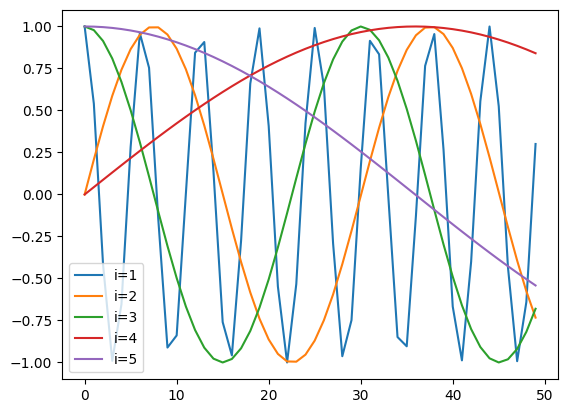

In [1]:
import matplotlib
import numpy as np
from matplotlib import pyplot as plt

matplotlib.font_manager.fontManager.addfont("NotoEmoji-Medium.ttf")

L = 50
d_e = 5
x = np.arange(L)
for i in range(1, 1 + d_e):
    if i % 2 == 0:
        w_p = np.sin(x / L ** (i / d_e))
    else:
        w_p = np.cos(x / L ** ((i - 1) / d_e))
    _ = plt.plot(x, w_p, label=f"i={i}")
plt.legend()

So this embedding seems to embed words at different frequencies for each component. I suspect that this allows us to consider the position in a short context at the same time.

# Self-Attention
The main component of the Transformer is *self-attention*, which models the importance of every combination of tokens in the input token sequence. Specifically, self-attention for a single query uses the embedding $e_t$ from the current token and the embeddings $e_0, e_1, ..., of all tokens in $x$. , e_{Nv} \in E$, we perform:
$$
\begin{align*}
q_t &\leftarrow W_q e_t + b_q \\
k_{t'} &\leftarrow W_k e_{t'} + b_k,~\forall e_{t'} \in E \\
v_{t'} &\leftarrow W_v e_{t'} + b_v,~\forall e_{t'} \in E \\
\alpha_{t'} &\leftarrow \frac{\exp(q_t^\top k_{t'} / \sqrt{d_{\textrm{attn}}})}{\sum_u \exp(q_t^\top k_{t'} / \sqrt{d_{\textrm{attn}}})},~\forall e_{t'} \in E \\
v_\textrm{attr} &\leftarrow \sum_{t = 1}^T \alpha_{t'} v_{t'}.
\end{align*}
$$
Let $d_\textrm{in}$ be the length of the embedding and $d_\textrm{out}$ the length of the output vector, $W_q, Q_k$ is the $d_\textrm{attn} \times e$ matrix, $W_q, Q_k$ is the $d_\textrm{out} \times d_\textrm{ in}$ matrices, and $b_q, b_k, b_v$ are vectors with proper shapes. Here, we want this to represent "how well the current token corresponds" to the $t'$th token, since we will mask $v$ by the probability marice obtained by applying softmax to $q^\top k_{t'}$. What $v_{t'}$ represents will vary from task to task, but it should contain values that are linearly related to the embedding of the $t'$th token. If there is no backward causality in this token sequence (a token $x[t]$ does not depend on any future token $x[t']~\textrm{where}~t < t'$), $\alpha_{t'}$ is often masked ($\alpha_{t'}[i] = 0 ~\textrm{if}~t < i$). It seems common to apply this mask when predicting the future.

In practice, when predicting something (next word, label, etc.) from a time series, this Attention for single query is computed for all tokens in the series of length $T$ to obtain a matrix $\tilde{V}$ with shape $d_textrm{out} \times T$.

# Let's do it

Let's train this self-attention layer. This time, I use [jax](https://jax.readthedocs.io/en/latest/) and [equinox](https://docs.kidger.site/equinox/).

In [2]:
import equinox as eqx
import jax
import jax.numpy as jnp


class Attention(eqx.Module):
    w_q: jax.Array
    b_q: jax.Array
    w_k: jax.Array
    b_k: jax.Array
    w_v: jax.Array
    b_v: jax.Array
    sqrt_d_attn: float

    def __init__(self, d_in: int, d_attn: int, d_out: int, key: jax.Array) -> None:
        wq_key, bq_key, wk_key, bk_key, wv_key, bv_key = jax.random.split(key, 6)
        self.w_q = jax.random.normal(wq_key, (d_attn, d_in))
        self.b_q = jax.random.normal(bq_key, (d_attn, 1))
        self.w_k = jax.random.normal(wk_key, (d_attn, d_in))
        self.b_k = jax.random.normal(bk_key, (d_attn, 1))
        self.w_v = jax.random.normal(wv_key, (d_out, d_in))
        self.b_v = jax.random.normal(bv_key, (d_out, 1))
        self.sqrt_d_attn = float(np.sqrt(d_attn))

    def __call__(self, e: jax.Array) -> jax.Array:
        """Take a matrix e with shape [d_in x seq_len], compute attention for all tokens in e.
        Outputs a matrix with shape [d_out x seq_len]
        """
        q = self.w_q @ e + self.b_q
        k = self.w_k @ e + self.b_k
        v = self.w_v @ e + self.b_v
        alpha = jax.nn.softmax(q.T @ k / self.sqrt_d_attn, axis=-1)
        return v @ alpha.T


def causal_mask(x: jax.Array, fill: jax.Array = -jnp.inf) -> jax.Array:
    ltri = jnp.tri(x.shape[0], dtype=bool, k=-1)
    return jax.lax.select(ltri, jnp.ones_like(x) * fill, x)


class MaskedAttention(Attention):
    def __call__(self, e: jax.Array) -> jax.Array:
        q = self.w_q @ e + self.b_q
        k = self.w_k @ e + self.b_k
        v = self.w_v @ e + self.b_v
        score = causal_mask(q.T @ k) / self.sqrt_d_attn
        alpha = jax.nn.softmax(score, axis=-1)
        return v @ alpha.T

Let's make this a learning experience. Consider the weather 🌧️, ☁️, and ☀️ as tokens. Let's give the appropriate embedding to these three symbols and let them learn the weather for the next day. Although this method is completely different from the method generally used in Transformer, we will use a vector with 4 elements as the embedding so that it can be learned with as simple a network as possible, as shown below.
- $e[0]$: 1 if the weather is 🌧️, 0 otherwise
- $e[1]$: 1 if the weather is ☁️, 0 otherwise
- $e[2]$: 1 if the weather is ☀️, 0 otherwise
- $e[3]$: $t/L$ (position embedding)

Let the maximum string length $L$ 20.

In [3]:
WEATHERS = ["🌧️", "☁️", "☀️"]
MAX_SEQ_LEN = 20

def get_embedding(seq: str) -> np.ndarray:
    length = len(seq) // 2
    e = np.zeros((4, length))
    for i in range(length):
        w = seq[i * 2: i * 2 + 2]
        e[WEATHERS.index(w), i] = 1.0
        e[3, i] = (i + 1) / MAX_SEQ_LEN
    return e

## Training a Markov model

Let's start with a simple model to generate the weather. **Let's assume that the next day's weather is stochastically determined** based on the previous day's weather. Note that 🌧️, ☁️, and ☀️ are multibyte characters, and implement the following.

In [4]:
import dataclasses

_GEN = np.random.Generator(np.random.PCG64(20230508))
_MARKOV = {
    "": [0.3, 0.4, 0.3],
    "🌧️": [0.6, 0.3, 0.1],
    "☁️": [0.3, 0.4, 0.3],
    "☀️": [0.2, 0.3, 0.5],
}

def markov(prev: str) -> str:
    prob = _MARKOV[prev[-2:]]
    return prev + _GEN.choice(WEATHERS, p=prob)


def generate(f, n: int, init: str = ""):
    value = init
    for _ in range(n):
        value = f(value)
    return value


@dataclasses.dataclass
class Dataset:
    weathers: list[str]
    embeddings: jax.Array
    next_weather_indices: jax.Array
    
    def __len__(self) -> int:
        return len(self.weathers)


def make_dataset(f, seq_len, size) -> Dataset:
    w_list, e_list, nw_list = [], [], []
    for _ in range(size):
        weathers = generate(f, seq_len + 1)
        e = jnp.array(get_embedding(weathers[:-2]))
        w_list.append(weathers)
        e_list.append(e)
        nw_list.append(WEATHERS.index(weathers[-2:]))
    return Dataset(w_list, jnp.stack(e_list), jnp.array(nw_list))


generated = generate(markov, 10)
generated, get_embedding(generated)

('🌧️🌧️🌧️☀️🌧️☁️🌧️🌧️☀️☀️',
 array([[1.  , 1.  , 1.  , 0.  , 1.  , 0.  , 1.  , 1.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  ],
        [0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]]))

The generated weathers look like this. Since we now only want to predict the weather for the next day, the output of the model should be a probability distribution over a set {🌧️, ☁️, ☀️}. Since Self-Attention will return a $d_\textrm{out} \times T$ matrix for an embedded column of length $T$, we set $d_\textrm{out} = 3$ and apply the softmax function to Attention's output $\tilde{V}$ to obtain $P_t = \textrm{softmax}(\tilde{V}[:, t])$. We model each element of $P_t$ as representing the probability that it will be on the next day 🌧️, ☁️, or ☀️. Let this be trained to maximize the sum of log-likelihood $\sum_t \log P_t(\textrm{next weather})$.

In [5]:
from typing import Callable

import optax


def attn_neglogp(model: eqx.Module, seq: jax.Array, next_w: jax.Array) -> jax.Array:
    batch_size = seq.shape[0]
    tilde_v = jax.vmap(model)(seq)  # B x OUT x SEQ_LEN
    logp = jax.nn.log_softmax(tilde_v, axis=1)  # B x OUT x SEQ_LEN
    logp_masked = logp * jax.nn.one_hot(next_w, num_classes=3).reshape(-1, 3, 1)
    return -jnp.mean(jnp.sum(logp_masked.reshape(batch_size, -1), axis=-1))

def train(
    n_total_epochs: int,
    minibatch_size: int,
    model: eqx.Module,
    ds: Dataset,
    test_ds: Dataset,
    key: jax.Array,
    learning_rate: float = 1e-2,
    loss_fn: Callable[[eqx.Module, jax.Array, jax.Array], jax.Array] = attn_neglogp,
) -> tuple[eqx.Module, jax.Array, list[float], list[float]]:
    n_data = len(ds)
    optim = optax.adam(learning_rate)

    @eqx.filter_jit
    def train_1step(
        model: eqx.Module,
        seq: jax.Array,
        next_w: jax.Array,
        opt_state: optax.OptState,
    ) -> tuple[jax.Array, eqx.Module, optax.OptState]:
        loss, grads = eqx.filter_value_and_grad(loss_fn)(model, seq, next_w)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    opt_state = optim.init(model)
    n_optim_epochs = n_data // minibatch_size
    loss_list, eval_list = [], []
    for epoch in range(n_total_epochs // n_optim_epochs):
        key, perm_key = jax.random.split(key)
        indices = jax.random.permutation(perm_key, n_data, independent=True)
        for _ in range(n_optim_epochs):
            e = ds.embeddings[indices]
            next_w = ds.next_weather_indices[indices]
            loss, model, opt_state = train_1step(model, e, next_w, opt_state)
            loss_list.append(loss.item())
            test_loss = jax.jit(loss_fn)(
                model,
                test_ds.embeddings,
                test_ds.next_weather_indices,
            )
            eval_list.append(test_loss.item())
    return model, key, loss_list, eval_list

Let's run it. I use $6$ for $d_textrm{attn}$ and $10$ for the sequence length $T$.

'Accuracy: 0.49800002574920654'

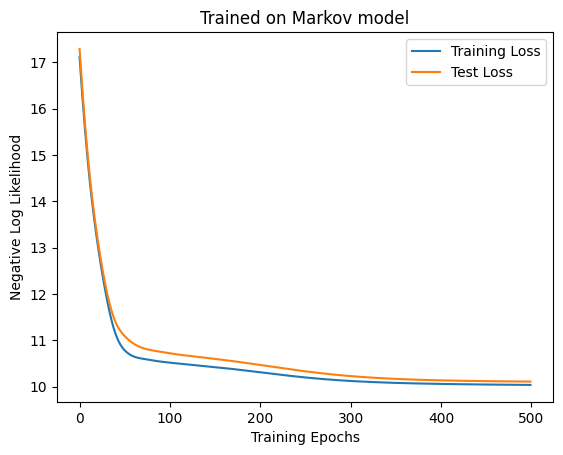

In [6]:
D_ATTN = 6
SEQ_LEN = 10
key = jax.random.PRNGKey(1234)
model = MaskedAttention(4, D_ATTN, 3, key)
ds = make_dataset(markov, SEQ_LEN, 1000)
test_ds = make_dataset(markov, SEQ_LEN, 1000)
model, key, loss_list, eval_list = train(500, 100, model, ds, test_ds, key, 1e-2)
plt.plot(loss_list, label="Training Loss")
plt.plot(eval_list, label="Test Loss")
plt.title("Trained on Markov model")
plt.xlabel("Training Epochs")
plt.ylabel("Negative Log Likelihood")
plt.legend()

@jax.jit
def accuracy(model: eqx.Module, seq: jax.Array, next_w: jax.Array) -> float:
    tilde_v = jax.vmap(model)(seq)  # B x OUT x SEQ_LEN
    inferred = jnp.argmax(tilde_v[:, :, 0], axis=1)
    n_correct = jnp.sum(inferred == next_w)
    return n_correct / seq.shape[0]

f"Accuracy: {accuracy(model, test_ds.embeddings, test_ds.next_weather_indices).item()}"

The loss is no longer dropping around 100 epochs, so it seemes to have converged. Let's see what has actually been learned. For now, let's try generating weather. This is not very meaningful in this case, but I thought it would be good to learn the generative process. It seems that the beam search is often used, but since it's complex, I use a simpler method this time. Starting from ☁️, we sample the next weather from the categorical distribution, and keep adding to it.

In [7]:
def generate_from_model(
    model: eqx.Module,
    key: jax.Array,
    seq_len: int,
    init: str = "☁️",
) -> tuple[str, jax.Array]:
    @jax.jit
    def step(
        model: eqx.Module,
        seq: jax.Array,
        key: jax.Array,
    ) -> tuple[jax.Array, jax.Array]:
        sample_key, key = jax.random.split(key)
        tilde_v = model(seq)  # 3 x len(seq)
        sampled = jax.random.categorical(key=sample_key, logits=tilde_v[:, 0])
        return sampled, key

    generated = init
    for _ in range(seq_len):
        next_w, key = step(model, get_embedding(generated), key)
        generated += WEATHERS[next_w.item()]
    return generated, key


generated, key = generate_from_model(model, key, 20)
generated

'☁️🌧️🌧️☀️🌧️☁️🌧️☀️☀️☀️☁️☁️☀️☀️☀️☀️☀️☁️☁️☀️☁️'

This is what the predicted weathers look like. Of course, this doesn't tell us anything. Next, let's visualize the contents of Self-Attention for some data in the test data.

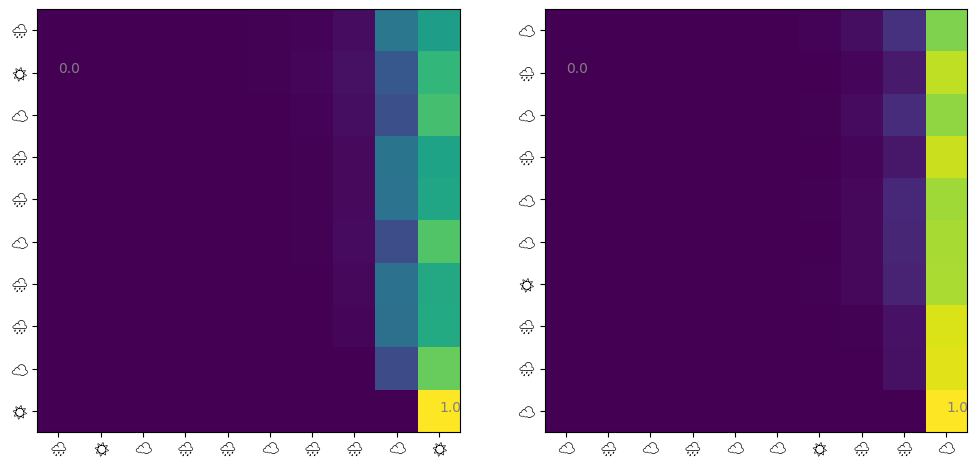

In [9]:
@jax.jit
def get_attn(model: eqx.Module, seq: jax.Array) -> jax.Array:
    q = model.w_q @ seq + model.b_q
    k = model.w_k @ seq + model.b_k
    score = causal_mask(q.T @ k) / model.sqrt_d_attn
    return jax.nn.softmax(score, axis=-1)


def visualize_attn(ax, model: eqx.Module, ds: Dataset, index: int = 0) -> None:
    attn = np.array(get_attn(model, ds.embeddings[index]))
    im = ax.imshow(attn)
    ax.set_xticks(
        np.arange(10),
        labels=[ds.weathers[index][i * 2] for i in range(10)],
        fontname="Noto Emoji",
    )
    ax.set_yticks(
        np.arange(10),
        labels=[ds.weathers[index][i * 2] for i in range(10)],
        fontname="Noto Emoji",
    )
    for i in [np.argmin(attn), np.argmax(attn)]:
        # Show min and max values
        im.axes.text(i % 10, i // 10, f"{attn.flatten()[i]:.1f}", color="gray")


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
visualize_attn(ax1, model, test_ds, 1)
visualize_attn(ax2, model, test_ds, 2)

Note that I could not use color emojis in matplotlib. We observe that:
1. 'last day -> last day' has the largest attention
2. 'other days -> last day' also has larger Attention
3. the other factors are almost irrelevant

The first is natural since we trained a weather sequence generated from a Markov model. The attentions from other days to last days are actually unnecessary, but also were taken.

## When future events depend on multiple independently occurring past events
Next, let's train some more complex data. This time, we will generate 11 days of weather in the following way:
1. Generate weather for days 1, 4, and 8 independently
2. Generate the weather for days 2 and 3 using a Markov chain with the weather for day 1 as the initial condition; generate the weather for days 5, 6, 7, 9, and 10 in the same way, based on the weather for days 4 and 8.
3. Generate the weather for day 11 stochastically based on the weather for days 1, 4, and 8.

Let's see if the self-attention layer can learn this.

In [10]:
def _make_table() -> dict[str, list[float]]:
    candidates = []
    for i in range(1, 9):
        for j in range(1, 9):
            for k in range(1, 9):
                if i + j + k == 10:
                    candidates.append((i, j, k))
    table = {}
    for i in WEATHERS:
        for j in WEATHERS:
            for k in WEATHERS:
                table[i + j + k] = [p / 10 for p in _GEN.choice(candidates)]
    return table

_ONE_FOUR_8_TABLE = _make_table()

def one_four_8(prev: str) -> str:
    length = len(prev) // 2
    if length == 10:
        p = _ONE_FOUR_8_TABLE[prev[0: 2] + prev[6: 8] + prev[14: 16]]
        return prev + _GEN.choice(WEATHERS, p=p)
    elif length == 4 or length == 8:
        return prev + _GEN.choice(WEATHERS, p=_MARKOV[""])
    else:
        return markov(prev)
    
generate(one_four_8, 11)

'☀️☁️☁️☀️🌧️🌧️☁️☀️🌧️🌧️🌧️'

OK, let's do it.

'Accuracy: 0.4020000100135803'

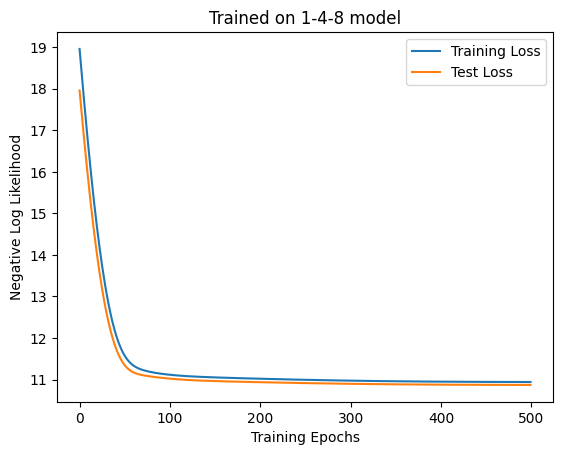

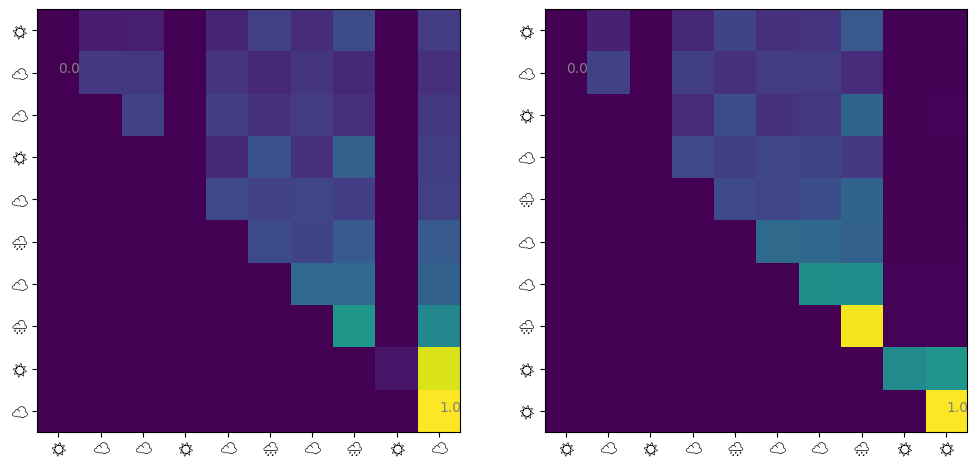

In [11]:
model = MaskedAttention(4, D_ATTN, 3, key)
ds = make_dataset(one_four_8, SEQ_LEN, 5000)
test_ds = make_dataset(one_four_8, SEQ_LEN, 1000)
model, key, loss_list, eval_list = train(500, 100, model, ds, test_ds, key, 1e-2)
plt.plot(loss_list, label="Training Loss")
plt.plot(eval_list, label="Test Loss")
plt.title("Trained on 1-4-8 model")
plt.xlabel("Training Epochs")
plt.ylabel("Negative Log Likelihood")
plt.legend()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
visualize_attn(ax1, model, test_ds, 1)
visualize_attn(ax2, model, test_ds, 2)

f"Accuracy: {accuracy(model, test_ds.embeddings, test_ds.next_weather_indices).item()}"

It converged, but the accuracy is poor and the attention is also not very effective. Attentions are given to days 1, 4, and 8, but as in the previous experiment, the last day's attention is larger.

## Do we need attention?

As smart readers may have noticed, we don't need self-attention to represent the two weather sequences we have learned so far. This is because the internal correlation of the input weather sequence has no bearing on the task at all, since the first one determines the weather of the previous day (day 10) and the next one determines the weather of days 1, 4, 8 to 11. So, let's train with a linear model + softmax (the so-called multinomial logistic regression).

'Accuracy: 0.44200003147125244'

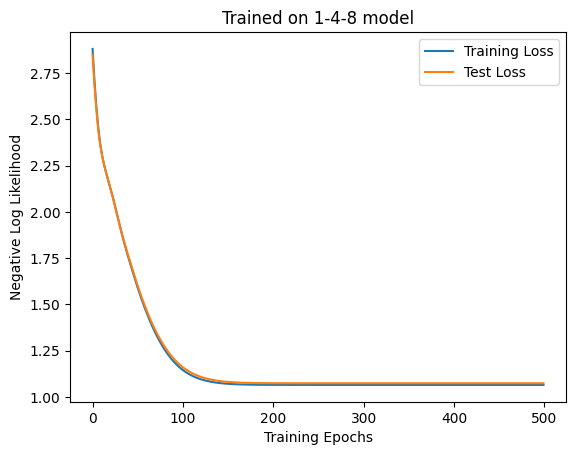

In [12]:
class LinearModel(eqx.Module):
    w: jax.Array
    b: jax.Array

    def __init__(self, d_in: int, d_out: int, key: jax.Array) -> None:
        w_key, b_key = jax.random.split(key)
        self.w = jax.random.normal(w_key, (d_out, d_in))
        self.b = jax.random.normal(b_key, (d_out,))

    def __call__(self, seq: jax.Array) -> jax.Array:
        return self.w @ seq.flatten() + self.b


def linear_neglogp(model: eqx.Module, seq: jax.Array, next_w: jax.Array) -> jax.Array:
    logp = jax.nn.log_softmax(jax.vmap(model)(seq), axis=1)  # B x OUT
    logp_masked = logp * jax.nn.one_hot(next_w, num_classes=3)
    return -jnp.mean(jnp.sum(logp_masked, axis=1))


model = LinearModel(4 * SEQ_LEN, 3, key)
model, key, loss_list, eval_list = train(
    500, 100, model, ds, test_ds, key, 1e-2, linear_neglogp
)
plt.plot(loss_list, label="Training Loss")
plt.plot(eval_list, label="Test Loss")
plt.title("Trained on 1-4-8 model")
plt.xlabel("Training Epochs")
plt.ylabel("Negative Log Likelihood")
plt.legend()


@jax.jit
def linear_accuracy(model: eqx.Module, seq: jax.Array, next_w: jax.Array) -> float:
    tilde_v = jax.vmap(model)(seq)  # B x OUT
    inferred = jnp.argmax(tilde_v, axis=1)
    n_correct = jnp.sum(inferred == next_w)
    return n_correct / seq.shape[0]


f"Accuracy: {linear_accuracy(model, test_ds.embeddings, test_ds.next_weather_indices).item()}"

This looks better. So, when is the self-attention useful?

1. (Compared to MLP, etc.) when you don't want to make the number of parameters depend on the length $L$ of the token sequence

Note that in self-attention the number of parameters is $(d_\textrm{in} + 1)(2d_\textrm{attn} + d_\textrm{out})$, while in the linear model it is $(d_\textrm{in}L + 1)d_\textrm{out}$. In the linear model, the number of parameters increases linearly with the length of the token sequence. Note, however, that self-attention requires $O(L^2)$ memory usage for $q^\top k$, although [Self-attention Does Not Need $O(n^2)$ Memory](https://arxiv.org/abs/2112.05682) shows an efficient $O(\sqrt{L})$ implementation. Still, it may be consume more memory thatn simple RNN or CNN.

2. (Compared to RNN, CNN, etc.) when there is a long-term dependency in the token series

Compared to CNN and RNN, the advantage of self-attention is that $q^\top k$ can represent arbitrary dependencies between tokens in one layer. However, since $q^\top k[i, j]$ is obtained only by linear operations on the two embeddings $e[i], e[j]$, if the two embeddings are dependent via some nonlinear function, the relationship cannot be represented by a single self-attention layer.

3. (Compared to RNN) when you want to do fast and parallel batch training

The operation of computing self-attention, namely the computation of $\textrm{softmax}(q^\top k)$ can be parallelized per query. This is useful when you want to get a parallelized implementation that works fast on single or many GPUs.

So, although it has the advantage of not depending on $L$ for the number of parameters compared to one linear layer, I am not sure if the self-attention can actually be more expressive or efficient. Let another blog post do some more theoretical stuff, I will try some more.

## When there are hidden variables

Generate a weather sequence in the following way. Look at the weather for the past $n$ days, and if 🌧️ has appeared $k$ times, let $\frac{n - k}{2n}$ be the probability that the weather for the next day will be 🌧️. Assign probabilities for ☁️ and ☀️ in the same way. Generate a long weather sequence in this way and create a dataset by gathering randomly sampled subsequences.

In [13]:
from functools import partial

def ndays_model(prev: str, n: int = 10) -> str:
    counts = np.zeros(3)
    prev_n = prev[-2 * n: ]
    for i in range(n):
        prev_w_i = prev_n[i * 2: i * 2 + 2]
        counts[WEATHERS.index(prev_w_i)] += 1
    prob = (n - counts) / (n * 2)
    return prev + _GEN.choice(WEATHERS, p=prob)

generate(ndays_model, 100, generate(markov, 10))                

'☁️🌧️🌧️🌧️🌧️🌧️🌧️🌧️☁️☀️☀️☁️☁️🌧️☁️🌧️☀️🌧️☀️☁️☀️☁️☀️☁️☀️☁️☀️🌧️☀️☁️🌧️☀️🌧️☀️☀️🌧️☀️🌧️☁️☁️🌧️☁️☁️☁️☀️🌧️☀️☀️☀️☀️☁️☁️🌧️🌧️🌧️🌧️🌧️☁️☀️☁️☀️☀️☀️☀️🌧️🌧️🌧️🌧️🌧️☀️☁️🌧️☁️☀️☀️☀️☁️☁️☀️🌧️☁️🌧️☁️☀️☀️☁️☁️☁️☁️☁️🌧️☁️🌧️☀️🌧️🌧️☀️☀️☁️🌧️☀️☀️🌧️☀️☁️☀️☀️☁️☁️☀️'

The generated weather sequence looks like this. First, let's traing the linear model on a 10-day model. In this case there is no hidden variable.

'Accuracy: 0.41600000858306885'

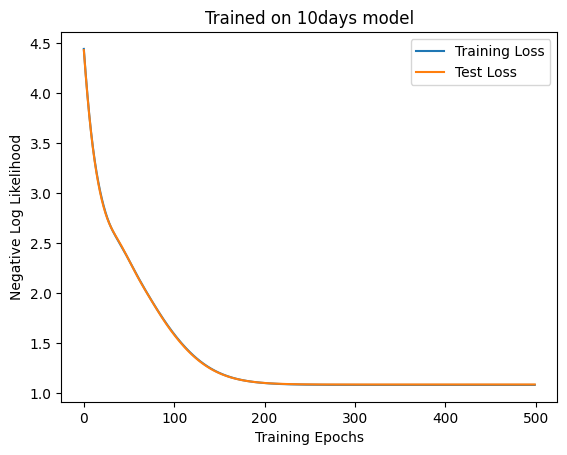

In [14]:
def make_ndays_dataset(seq_len, size, n: int = 10) -> Dataset:
    weathers = generate(partial(ndays_model, n=n), seq_len * size * 2, generate(markov, n * 2))
    w_list, e_list, nw_list = [], [], []
    for _ in range(size):
        start = _GEN.integers(0, seq_len * size * 2 - 11)
        w = weathers[start * 2 : start * 2 + (seq_len + 1) * 2]
        e = jnp.array(get_embedding(w[:-2]))
        w_list.append(w)
        e_list.append(e)
        nw_list.append(WEATHERS.index(w[-2:]))
    return Dataset(w_list, jnp.stack(e_list), jnp.array(nw_list))


ds = make_ndays_dataset(SEQ_LEN, 5000, n=10)
test_ds = make_ndays_dataset(SEQ_LEN, 1000, n=10)

model = LinearModel(4 * SEQ_LEN, 3, key)
model, key, loss_list, eval_list = train(
    500, 100, model, ds, test_ds, key, 1e-2, linear_neglogp
)
plt.plot(loss_list, label="Training Loss")
plt.plot(eval_list, label="Test Loss")
plt.title("Trained on 10days model")
plt.xlabel("Training Epochs")
plt.ylabel("Negative Log Likelihood")
plt.legend()

f"Accuracy: {linear_accuracy(model, test_ds.embeddings, test_ds.next_weather_indices).item()}"

Train the self-attention layer next.

'Accuracy: 0.3630000054836273'

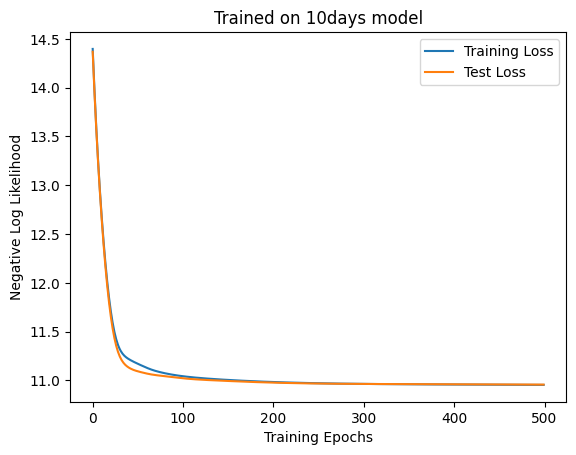

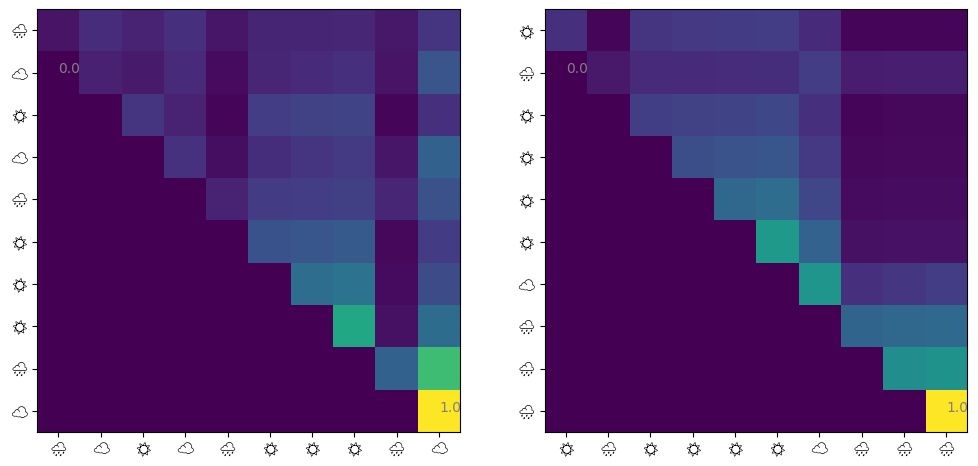

In [15]:
model = MaskedAttention(4, D_ATTN, 3, key)
model, key, loss_list, eval_list = train(500, 100, model, ds, test_ds, key, 1e-2)
plt.plot(loss_list, label="Training Loss")
plt.plot(eval_list, label="Test Loss")
plt.title("Trained on 10days model")
plt.xlabel("Training Epochs")
plt.ylabel("Negative Log Likelihood")
plt.legend()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
visualize_attn(ax1, model, test_ds, 1)
visualize_attn(ax2, model, test_ds, 2)

f"Accuracy: {accuracy(model, test_ds.embeddings, test_ds.next_weather_indices).item()}"

The self-attention is now worse than the linear model. Next, let's turn the 10-day model into a 15-day model with hidden variables. First, we train the linear layer.

'Accuracy: 0.34200000762939453'

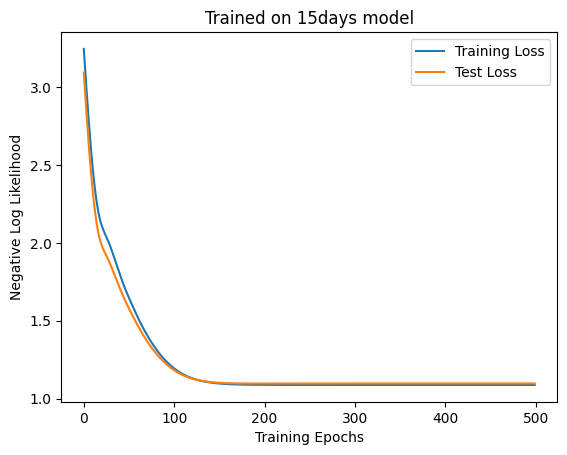

In [16]:
ds = make_ndays_dataset(SEQ_LEN, 5000, n=15)
test_ds = make_ndays_dataset(SEQ_LEN, 1000, n=15)

model = LinearModel(4 * SEQ_LEN, 3, key)
model, key, loss_list, eval_list = train(
    500, 100, model, ds, test_ds, key, 1e-2, linear_neglogp
)
plt.plot(loss_list, label="Training Loss")
plt.plot(eval_list, label="Test Loss")
plt.title("Trained on 15days model")
plt.xlabel("Training Epochs")
plt.ylabel("Negative Log Likelihood")
plt.legend()

f"Accuracy: {linear_accuracy(model, test_ds.embeddings, test_ds.next_weather_indices).item()}"

Then train the self-attention layer.

'Accuracy: 0.35600000619888306'

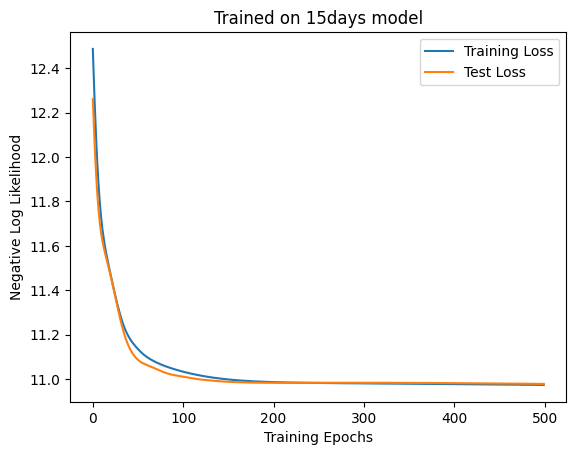

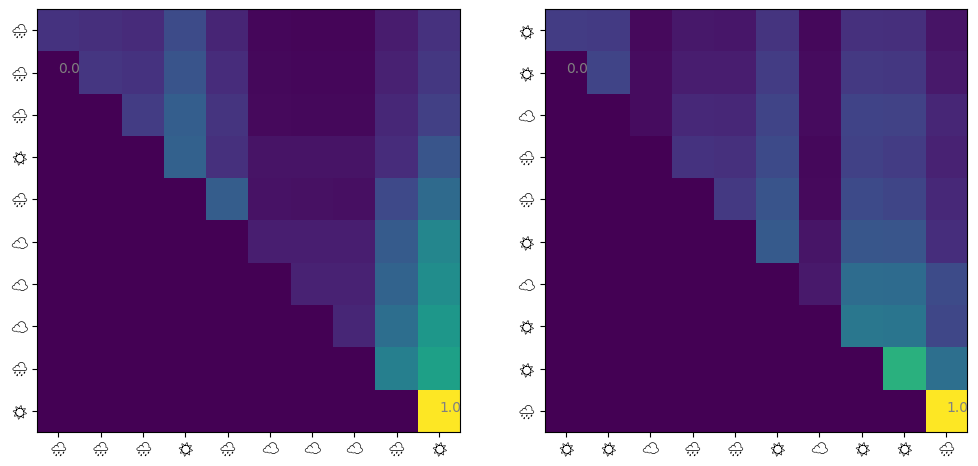

In [17]:
model = MaskedAttention(4, D_ATTN, 3, key)
model, key, loss_list, eval_list = train(500, 100, model, ds, test_ds, key, 1e-2)
plt.plot(loss_list, label="Training Loss")
plt.plot(eval_list, label="Test Loss")
plt.title("Trained on 15days model")
plt.xlabel("Training Epochs")
plt.ylabel("Negative Log Likelihood")
plt.legend()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
visualize_attn(ax1, model, test_ds, 1)
visualize_attn(ax2, model, test_ds, 2)

f"Accuracy: {accuracy(model, test_ds.embeddings, test_ds.next_weather_indices).item()}"

Attention is a bit better, but there is no meaningful difference in accuracy.

## What about non-linear?

If the linear model performs better even with hidden variables, it probably means that the task is still linearly solvable. So let's consider more difficult nonlinear data.
Let $y$ be a vector created by assigning 0, 1, and 2 to 🌧️, ☁️, and ☀️ in the 10-day weather sequence, respectively. Also, let $\beta = (0, 1, 2, 3, 2, 1, 0, 1, 2, 3)^\top$. Let $(y(2 - y)\cdot \beta)\mod 3$ be the weather for the next day. To make the data a bit stohcastic, let's assign other weathers 2% probability.

In [18]:
_BETA = np.tile([0, 1, 2, 3, 2, 1], (10,))

def dotmod_model(prev: str, n: int =10) -> str:
    y = np.zeros(n, dtype=int)
    prev_n = prev[-2 * n:]
    for i in range(n):
        prev_w_i = prev_n[i * 2: i * 2 + 2]
        y[i] = WEATHERS.index(prev_w_i) + 1
    prob = [0.02, 0.02, 0.02]
    prob[np.dot(y * (2 - y), _BETA[: n]) % 3] = 0.96
    return prev + _GEN.choice(WEATHERS, p=prob)

def make_dotmod_dataset(seq_len, size, n: int = 10) -> Dataset:
    weathers = generate(partial(dotmod_model, n=n), seq_len * size * 2, generate(markov, n * 2))
    w_list, e_list, nw_list = [], [], []
    for _ in range(size):
        start = _GEN.integers(0, seq_len * size * 2 - 11)
        w = weathers[start * 2 : start * 2 + (seq_len + 1) * 2]
        e = jnp.array(get_embedding(w[:-2]))
        w_list.append(w)
        e_list.append(e)
        nw_list.append(WEATHERS.index(w[-2:]))
    return Dataset(w_list, jnp.stack(e_list), jnp.array(nw_list))

generate(dotmod_model, 100, generate(markov, 10))

'☁️☁️☀️☀️☀️☀️☀️☀️☁️☁️☀️🌧️🌧️☀️🌧️☁️🌧️☁️☁️☁️☀️☀️☁️☁️☀️☁️🌧️🌧️☀️🌧️☁️🌧️☁️☁️🌧️☀️☁️☀️☁️🌧️🌧️☀️☀️☀️☁️🌧️☀️☁️☁️☁️☁️☀️🌧️☀️🌧️☁️☀️☀️☀️☁️☁️☁️☀️☁️☁️🌧️🌧️☀️🌧️☁️🌧️☁️☁️☁️☀️☀️☁️☁️☀️☁️🌧️🌧️☀️🌧️☁️🌧️☁️☁️☁️☀️☀️☁️☁️☀️☁️🌧️🌧️☀️☁️☁️☁️🌧️☀️☁️☁️☁️☁️☀️🌧️☀️'

We were able to generate a weather sequence that at a quick glance does not seem to be legal. Let's try to train it. Let's start with a linear model.

'Accuracy: 0.7440000176429749'

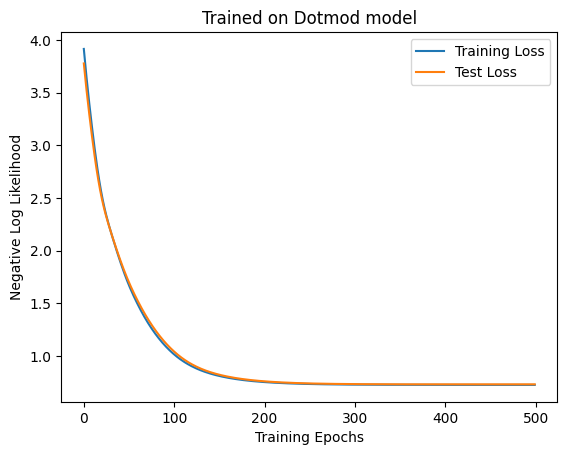

In [21]:
ds = make_dotmod_dataset(SEQ_LEN, 5000)
test_ds = make_dotmod_dataset(SEQ_LEN, 1000)

model = LinearModel(4 * SEQ_LEN, 3, key)
model, key, loss_list, eval_list = train(
    500, 100, model, ds, test_ds, key, 1e-2, linear_neglogp
)
plt.plot(loss_list, label="Training Loss")
plt.plot(eval_list, label="Test Loss")
plt.title("Trained on Dotmod model")
plt.xlabel("Training Epochs")
plt.ylabel("Negative Log Likelihood")
plt.legend()

f"Accuracy: {linear_accuracy(model, test_ds.embeddings, test_ds.next_weather_indices).item()}"

Suprsingly, the accuracy is quite high. Then let's train the self-attention layer.

'Accuracy: 0.4350000321865082'

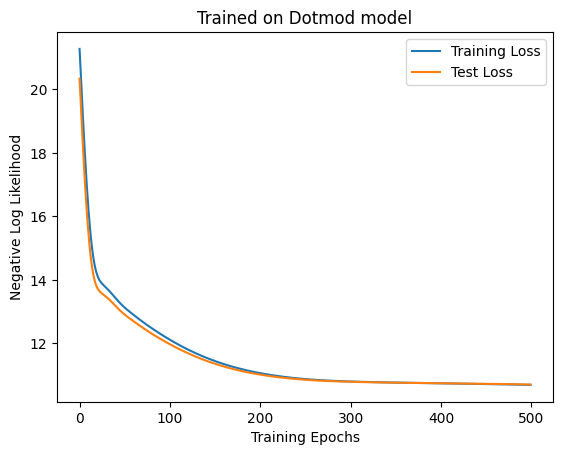

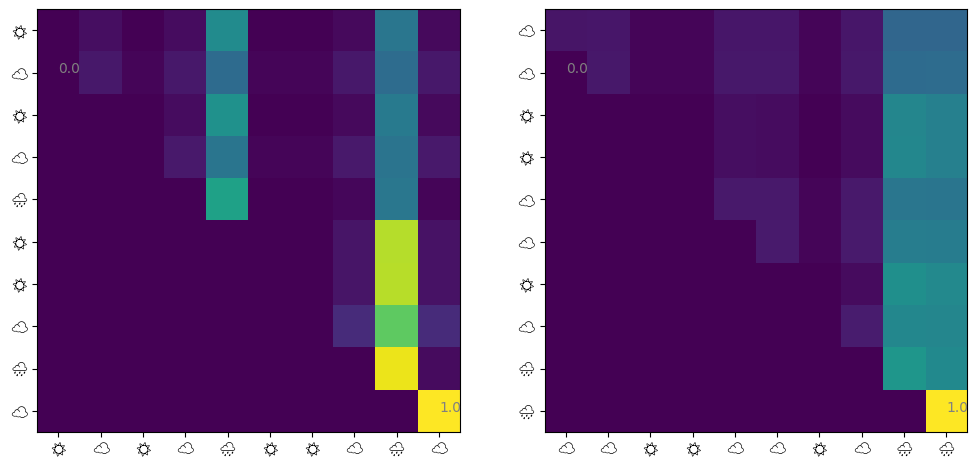

In [22]:
model = MaskedAttention(4, D_ATTN, 3, key)
model, key, loss_list, eval_list = train(500, 100, model, ds, test_ds, key, 1e-2)
plt.plot(loss_list, label="Training Loss")
plt.plot(eval_list, label="Test Loss")
plt.title("Trained on Dotmod model")
plt.xlabel("Training Epochs")
plt.ylabel("Negative Log Likelihood")
plt.legend()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
visualize_attn(ax1, model, test_ds, 1)
visualize_attn(ax2, model, test_ds, 2)

f"Accuracy: {accuracy(model, test_ds.embeddings, test_ds.next_weather_indices).item()}"

Again, the self-attention was not better. So maybe we can at least say that the self-attention itself is not very good at approximating nonlinear function like modulo.

# Summary

In this blog post, I gave an overview of what the single self-attention, a simplified version of Multihead Attention in Transformer, is doing. I also tried to train it on some simple data sets. It ended up with less than linear function performance on all tasks and honestly could not see any benefit other than memory usage. Now I feel like MLP can be scaled as Transformer scaled in the infamous OpenAI paper.
In future blogs, I will also want to try:
- The effect of MultiHead Attention
- Effects of Layer Normalization
- Introduction of theoretical papers
- Comparison with convolution, RNN, and linear state space models